# Master course in Object Recognition
## Practice 1

### Title: Deep learning advanced architectures

The goal is to practice advanced deep learning architectures for multi-label classification in [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html). We specifically check ResNet50, Inception and MobileNet. We will see 1) how pretrained ResNet50 on imagenet performs on multi-label images, 2) how to modify classification head and 3) implementation of F1 metric.

### NOTES

- Hyperparameters are modifiable,
- The dataset is PASCAL VOC 2012,
- The code uses the KERAS library,
- The code can run in google colab.
- How to finetune on a pretrained model not included (i.e. freeze the pretrained network and train the head, then finetune everything),
- No validation set has been defined. The test and validation sets are the same.

In [1]:
import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.18.0
Keras Version: 3.8.0


In [2]:
from glob import glob
import cv2
import random
import numpy as np
import xml.etree.ElementTree as ET
import keras
from keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import os
import tensorflow.keras.applications as app

batch_size = 32
n_epochs = 12
per_sample_normalization = True
data_augmentation = True
net_name = [['resnet50','ResNet50'], ['inception_v3','InceptionV3'], ['mobilenet_v2','MobileNetV2']][0]
train_from_scratch = True
last_layer_activation = ['softmax', 'sigmoid', None][1]
loss = ['categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'][1]
img_size = 224
num_classes = 20
voc_classes = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
test_imagenet = True
root = './VOCdevkit/VOC2012/'


In [3]:
# Read and format data
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_objects = []
    for boxes in root.iter('object'):

        classname = boxes.find("name").text
        list_with_all_objects.append(voc_classes[classname])

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_objects, list_with_all_boxes

def load_batch(data_list, step, batch_size, root, img_size):
  X, Y = [], []
  for f in data_list[step*batch_size : (step+1)*batch_size]:
    img = cv2.imread(root + 'JPEGImages/' + f + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = cv2.resize(img, (img_size, img_size))
    X.append(img)

    classes = np.zeros(num_classes)
    try:
      cnames, _ = read_content(root + 'Annotations/' + f +'.xml')
    except:
       print(f)
    for c in cnames:
        classes[c] = 1.0
    Y.append(classes)

  return (np.array(X), np.array(Y))

In [4]:
# F1 metric

def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
# Build the model

# Select the corresponding network class
mynet = getattr(getattr(app, net_name[0]), net_name[1])

# create the base pre-trained model
if train_from_scratch:
  base_model = mynet(include_top=False)
else:
  base_model = mynet(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(num_classes, activation=last_layer_activation)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
opt_rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(loss=loss, optimizer=opt_rms, metrics=['AUC', f1_metric])

In [6]:
#data augmentation
test_data_gen_args = dict(rescale = None if per_sample_normalization else 1./255,
                     samplewise_center=True if per_sample_normalization else False,
                     samplewise_std_normalization=True if per_sample_normalization else False)
train_data_gen_args = dict(rescale = None if per_sample_normalization else 1./255,
                     samplewise_center=True if per_sample_normalization else False,
                     samplewise_std_normalization=True if per_sample_normalization else False,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2) if data_augmentation else test_data_gen_args
training_datagen = ImageDataGenerator(**train_data_gen_args)
test_datagen = ImageDataGenerator(**test_data_gen_args)

In [ ]:
# Train and test loops

# Read the data lists
with open('train.txt', 'r') as f:
  train_list = f.readlines()
  for i in range(len(train_list)):
    train_list[i] = train_list[i].rsplit('\n',1)[0]
with open('test.txt', 'r') as f:
  test_list = f.readlines()
  for i in range(len(test_list)):
    test_list[i] = test_list[i].rsplit('\n',1)[0]
n_train_steps = len(train_list) // batch_size
n_test_steps = len(test_list) // batch_size

train_loss_history = []
train_acc_history = []
train_f1_history = []
test_loss_history = []
test_acc_history = []
test_f1_history = []
for epoch in range(n_epochs):
  # shuffle the list
  random.shuffle(train_list)

  # Training loop
  _loss = 0
  _acc = 0
  _f1 = 0
  for step in range(n_train_steps):
    # Load the batch
    X, Y = load_batch(train_list, step, batch_size, root, img_size)

    # Perform data augmentation
    X, Y = next(training_datagen.flow(X, Y, batch_size=batch_size, shuffle=False))

    # Train on one batch
    loss, acc, f1 = model.train_on_batch(X, Y)

    _loss += loss
    _acc += acc
    _f1 += f1
    train_loss_history.append(loss)
    train_acc_history.append(acc)
    train_f1_history.append(f1)

    # print the log
    current_step = step + 1
    print("Step {0} training loss: {1:.2f}, acc: {2:.2f}, f1: {3:.2f}".format(current_step, _loss/current_step, _acc/current_step, _f1/current_step))

  # print the log
  print("epoch {0} training loss: {1:.2f}, acc: {2:.2f}, f1: {3:.2f}\n".format(epoch, _loss/current_step, _acc/current_step, _f1/current_step))

  # Test loop
  _loss = 0
  _acc = 0
  _f1 = 0
  for step in range(n_test_steps):
    # Load the batch
    X, Y = load_batch(test_list, step, batch_size, root, img_size)

    # Perform data augmentation
    X, Y = next(test_datagen.flow(X, Y, batch_size=batch_size, shuffle=False))

    # Train on one batch
    loss, acc, f1 = model.evaluate(X, Y, verbose = 0)

    _loss += loss
    _acc += acc
  
    _f1 += f1
    test_loss_history.append(loss)
    test_acc_history.append(acc)
    test_f1_history.append(f1)

    # print the log
    current_step = step + 1
    print("step {0} test loss: {1:.2f}, acc: {2:.2f}, f1: {3:.2f}".format(current_step, _loss/current_step, _acc/current_step, _f1/current_step))

  # print the log
  print("epoch {0} test loss: {1:.2f}, acc: {2:.2f}, f1: {3:.2f}\n".format(epoch, _loss/current_step, _acc/current_step, _f1/current_step))

Step 1 training loss: 0.81, acc: 0.60, f1: 0.13
Step 2 training loss: 0.69, acc: 0.62, f1: 0.20
Step 3 training loss: 0.62, acc: 0.65, f1: 0.26
Step 4 training loss: 0.57, acc: 0.66, f1: 0.29
Step 5 training loss: 0.54, acc: 0.67, f1: 0.29
Step 6 training loss: 0.51, acc: 0.67, f1: 0.28
Step 7 training loss: 0.49, acc: 0.67, f1: 0.28
Step 8 training loss: 0.47, acc: 0.68, f1: 0.28
Step 9 training loss: 0.46, acc: 0.68, f1: 0.29
Step 10 training loss: 0.44, acc: 0.68, f1: 0.29
Step 11 training loss: 0.43, acc: 0.68, f1: 0.29
Step 12 training loss: 0.42, acc: 0.68, f1: 0.29
Step 13 training loss: 0.41, acc: 0.69, f1: 0.30
Step 14 training loss: 0.41, acc: 0.69, f1: 0.30
Step 15 training loss: 0.40, acc: 0.69, f1: 0.30
Step 16 training loss: 0.39, acc: 0.69, f1: 0.31
Step 17 training loss: 0.38, acc: 0.70, f1: 0.31
Step 18 training loss: 0.38, acc: 0.70, f1: 0.31
Step 19 training loss: 0.37, acc: 0.70, f1: 0.32
Step 20 training loss: 0.37, acc: 0.70, f1: 0.32
Step 21 training loss: 0.36, 

KeyboardInterrupt: 

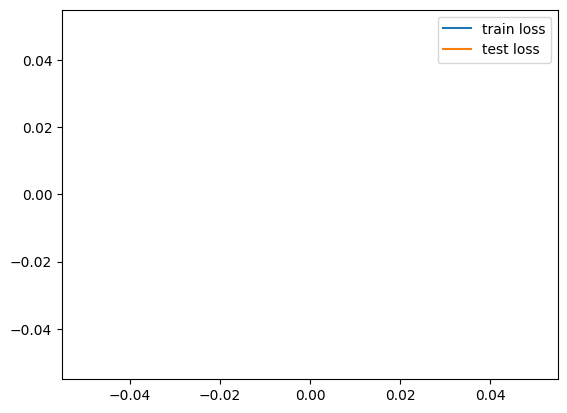

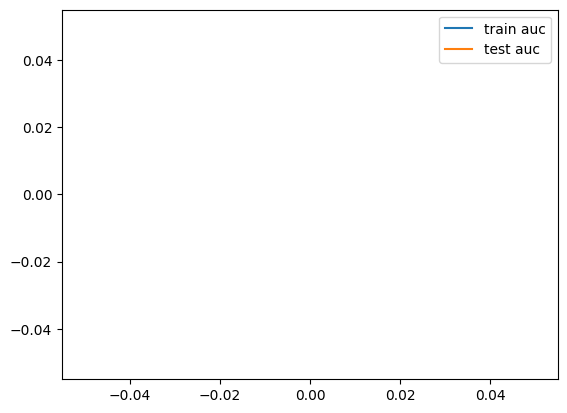

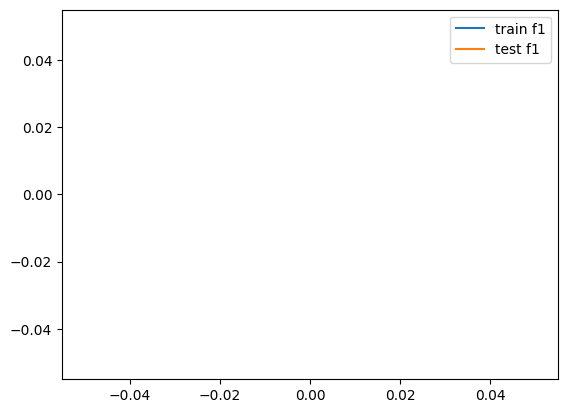

<Figure size 640x480 with 0 Axes>

: 

: 

In [ ]:
txt = "plot"

# plot the loss
plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.legend()
plt.show()
plt.savefig(txt+'_loss')

# plot the AUC
plt.plot(train_acc_history, label='train auc')
plt.plot(test_acc_history, label='test auc')
plt.legend()
plt.show()
plt.savefig(txt+'_auc')

# plot the F1
plt.plot(train_f1_history, label='train f1')
plt.plot(test_f1_history, label='test f1')
plt.legend()
plt.show()
plt.savefig(txt+'_f1')

#save model to disk
model.save_weights('model.h5')

: 

: 